In [6]:
import src.get_data as get_data
import src.load_data as load
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import datetime 

from keras.callbacks import History 
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model

import time
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8


import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

WINDOW = 22


In [7]:

def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model



In [12]:
df = get_data.get_data_frame()

df = df[:-1]

In [15]:
def nextDayPrediction(typeBlockchain, stock, N = 1):    
    
    plot = True
    plotHictory = True
    interactiveGrapth = True
    plotForTrain = False
    
    df = get_data.get_data_frame(typeBlockchain, stock)
    df = df[:-1]
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    all_df = df.copy()
    features = ['low', 'high']
    
    x = all_df[features].copy()
    
    y = all_df['close'].copy()
    
    x = pd.ewma(x,2)
    y = pd.ewma(y,2)
    
    NUM_FEATURES = x.shape[1]
    
    x[features] = x_scaler.fit_transform(x)

    y = y_scaler.fit_transform(y.values.reshape(-1, 1))
    #x['close'] = y
    
    #X_train, y_train = load.load_data(x, WINDOW, TrainTest = False)
    X_train, y_train, X_test, y_test = load.load_data(x, WINDOW, train_size= 0.96, TrainTest = True)
    
    model = build_model(input_shape=(WINDOW, NUM_FEATURES))
    
    print('START FIT MODEL...')
    
    start = time.time()
    
    history = History()
    history= model.fit(X_train, y_train, validation_data=(X_test, y_test),  batch_size=32, epochs=500,verbose=1,
              callbacks=[history])
    
    #model.fit(X_train, y_train, batch_size=32, epochs=500, verbose=1)
    end = time.time()

    print ('Learning time: ', end-start)
    
    today = time.strftime("_%d_%m_%Y")
    
    pathModel = "../../models/model_low_high_" + typeBlockchain + today +".h5"
    save_model(model, pathModel)
    
    #model = load_model(pathModel)
    # one day prediction. get last batch known data (now we didnt need in y value and can predict it)    
    lastbatch = np.array(x[-WINDOW:])
    pred = model.predict([lastbatch.reshape(1,22, NUM_FEATURES)])
    pred =  np.array(y_scaler.inverse_transform(pred)) # predicted value

    # now we make dataframe and create row names in date

    lastDate =str(df.date[df.last_valid_index()]).split('-')
    currentData = datetime.date(int(lastDate[0]),int(lastDate[1]),int(lastDate[2])) + datetime.timedelta(1)
    predictionDate = pd.date_range(currentData, periods=1)
    prediction = pd.DataFrame(pred, columns=["predictionPrice"], index = predictionDate.values)

    print (prediction)
    
    
    if plotForTrain:
        
        trainPredict = model.predict(X_train)
        trainPredict = y_scaler.inverse_transform(trainPredict)
        prices = df.close.values.astype('float32')
        prices = prices.reshape(len(prices), 1)
        trainPredictPlot = np.empty_like(prices)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict
        Actual = pd.DataFrame(prices, columns=["close"], index=df.index).close
        Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=df.date).close
        ActualValues = go.Scatter( x = df.date, y = Actual, name = 'ActualValues')
        TrainingValues = go.Scatter( x = df.date, y = Training, name = 'TrainingValues')

        iplot([ActualValues,TrainingValues])
        plt.show()
        
    if plot:
        trainPredict = model.predict(X_train)
        testPredict = model.predict(X_test)

        trainPredict = y_scaler.inverse_transform(trainPredict)
        trainY = y_scaler.inverse_transform([y_train])

        testPredict = y_scaler.inverse_transform(testPredict)
        testY = y_scaler.inverse_transform([y_test])

        trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
        print('Train Score: %.2f RMSE' % (trainScore))

        testScore = metrics.mean_squared_error(testY[0], testPredict[:,0]) ** .5
        print('Test Score: %.2f RMSE' % (testScore))
        prices = df.close.values.astype('float32')
        prices = prices.reshape(len(prices), 1)
        trainPredictPlot = np.empty_like(prices)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict

        testPredictPlot = np.empty_like(prices)
        testPredictPlot[:, :] = np.nan
        testPredictPlot[(len(prices) - testPredict.shape[0]):len(prices), :] = testPredict

        plt.plot(pd.DataFrame(prices, columns=["close"], index=df.index).close, label='Actual')
        plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
        plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
        plt.legend(loc='best')
        plt.show()

        interactiveGrapth = 1
        if interactiveGrapth:

            Actual = pd.DataFrame(prices, columns=["close"], index=df.index).close
            Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=df.date).close
            Testing = pd.DataFrame(testPredictPlot, columns=["close"], index=df.date).close

            ActualValues = go.Scatter( x = df.date, y = Actual, name = 'ActualValues')
            TrainingValues = go.Scatter( x = df.date, y = Training, name = 'TrainingValues')
            TestingValues = go.Scatter( x = df.date, y = Testing, name = 'PredictedValues')

            iplot([ActualValues,TrainingValues, TestingValues])
            plt.show()

        if plotHictory:

            plt.plot(history.history['loss'], label = 'TrainLoss')
            plt.plot(history.history['val_loss'], label = 'TestLoss')
            plt.legend()
            plt.show()

    return prediction,Testing

START FIT MODEL...
Train on 668 samples, validate on 28 samples
Epoch 1/500
668/668 [==============================] - 1s - loss: 0.0271 - acc: 0.0015 - val_loss: 0.0402 - val_acc: 0.0000e+00
Epoch 2/500
668/668 [==============================] - 0s - loss: 0.0023 - acc: 0.0015 - val_loss: 0.0086 - val_acc: 0.0000e+00
Epoch 3/500
668/668 [==============================] - 0s - loss: 0.0012 - acc: 0.0015 - val_loss: 0.0125 - val_acc: 0.0000e+00
Epoch 4/500
668/668 [==============================] - 0s - loss: 0.0012 - acc: 0.0015 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 5/500
668/668 [==============================] - 0s - loss: 0.0013 - acc: 0.0015 - val_loss: 0.0082 - val_acc: 0.0000e+00
Epoch 6/500
668/668 [==============================] - 0s - loss: 0.0013 - acc: 0.0015 - val_loss: 0.0082 - val_acc: 0.0000e+00
Epoch 7/500
668/668 [==============================] - 0s - loss: 0.0015 - acc: 0.0015 - val_loss: 0.0096 - val_acc: 0.0000e+00
Epoch 8/500
668/668 [===================

668/668 [==============================] - 0s - loss: 5.7475e-04 - acc: 0.0015 - val_loss: 0.0046 - val_acc: 0.0000e+00
Epoch 63/500
668/668 [==============================] - 0s - loss: 5.4613e-04 - acc: 0.0015 - val_loss: 0.0047 - val_acc: 0.0000e+00
Epoch 64/500
668/668 [==============================] - 0s - loss: 4.3552e-04 - acc: 0.0015 - val_loss: 0.0047 - val_acc: 0.0000e+00
Epoch 65/500
668/668 [==============================] - 0s - loss: 5.6013e-04 - acc: 0.0015 - val_loss: 0.0081 - val_acc: 0.0000e+00
Epoch 66/500
668/668 [==============================] - 0s - loss: 6.8514e-04 - acc: 0.0015 - val_loss: 0.0058 - val_acc: 0.0000e+00
Epoch 67/500
668/668 [==============================] - 0s - loss: 4.9325e-04 - acc: 0.0015 - val_loss: 0.0049 - val_acc: 0.0000e+00
Epoch 68/500
668/668 [==============================] - 0s - loss: 5.2311e-04 - acc: 0.0015 - val_loss: 0.0046 - val_acc: 0.0000e+00
Epoch 69/500
668/668 [==============================] - 0s - loss: 5.2832e-04 - ac

668/668 [==============================] - 0s - loss: 3.2512e-04 - acc: 0.0015 - val_loss: 0.0040 - val_acc: 0.0000e+00
Epoch 124/500
668/668 [==============================] - 0s - loss: 4.1270e-04 - acc: 0.0015 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 125/500
668/668 [==============================] - 0s - loss: 3.0189e-04 - acc: 0.0015 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 126/500
668/668 [==============================] - 0s - loss: 3.8783e-04 - acc: 0.0015 - val_loss: 0.0040 - val_acc: 0.0000e+00
Epoch 127/500
668/668 [==============================] - 0s - loss: 3.7276e-04 - acc: 0.0015 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 128/500
668/668 [==============================] - 0s - loss: 3.5384e-04 - acc: 0.0015 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 129/500
668/668 [==============================] - 0s - loss: 4.6623e-04 - acc: 0.0015 - val_loss: 0.0043 - val_acc: 0.0000e+00
Epoch 130/500
668/668 [==============================] - 0s - loss: 3.4407e-

668/668 [==============================] - 0s - loss: 2.8087e-04 - acc: 0.0015 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 185/500
668/668 [==============================] - 0s - loss: 4.1037e-04 - acc: 0.0015 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 186/500
668/668 [==============================] - 0s - loss: 5.0326e-04 - acc: 0.0015 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 187/500
668/668 [==============================] - 0s - loss: 3.4355e-04 - acc: 0.0015 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 188/500
668/668 [==============================] - 0s - loss: 4.6000e-04 - acc: 0.0015 - val_loss: 0.0049 - val_acc: 0.0000e+00
Epoch 189/500
668/668 [==============================] - 0s - loss: 4.3847e-04 - acc: 0.0015 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 190/500
668/668 [==============================] - 0s - loss: 3.7045e-04 - acc: 0.0015 - val_loss: 0.0045 - val_acc: 0.0000e+00
Epoch 191/500
668/668 [==============================] - 0s - loss: 4.0544e-

668/668 [==============================] - 0s - loss: 3.0764e-04 - acc: 0.0015 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 246/500
668/668 [==============================] - 0s - loss: 3.3097e-04 - acc: 0.0015 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 247/500
668/668 [==============================] - 0s - loss: 2.9100e-04 - acc: 0.0015 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 248/500
668/668 [==============================] - 0s - loss: 3.0072e-04 - acc: 0.0015 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 249/500
668/668 [==============================] - 0s - loss: 2.9691e-04 - acc: 0.0015 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 250/500
668/668 [==============================] - 0s - loss: 3.0791e-04 - acc: 0.0015 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 251/500
668/668 [==============================] - 0s - loss: 4.2584e-04 - acc: 0.0015 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 252/500
668/668 [==============================] - 0s - loss: 4.2218e-

668/668 [==============================] - 0s - loss: 2.6923e-04 - acc: 0.0015 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 307/500
668/668 [==============================] - 0s - loss: 3.6246e-04 - acc: 0.0015 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 308/500
668/668 [==============================] - 0s - loss: 2.8429e-04 - acc: 0.0015 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 309/500
668/668 [==============================] - 0s - loss: 3.1681e-04 - acc: 0.0015 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 310/500
668/668 [==============================] - 0s - loss: 3.0878e-04 - acc: 0.0015 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 311/500
668/668 [==============================] - 0s - loss: 2.8193e-04 - acc: 0.0015 - val_loss: 0.0036 - val_acc: 0.0000e+00cc: 0
Epoch 312/500
668/668 [==============================] - 0s - loss: 2.9044e-04 - acc: 0.0015 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 313/500
668/668 [==============================] - 0s - loss: 2.9

668/668 [==============================] - 0s - loss: 3.6143e-04 - acc: 0.0015 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 368/500
668/668 [==============================] - 0s - loss: 2.3835e-04 - acc: 0.0015 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 369/500
668/668 [==============================] - 0s - loss: 2.2018e-04 - acc: 0.0015 - val_loss: 0.0029 - val_acc: 0.0000e+00cc: 0
Epoch 370/500
668/668 [==============================] - 0s - loss: 2.7970e-04 - acc: 0.0015 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 371/500
668/668 [==============================] - 0s - loss: 2.9381e-04 - acc: 0.0015 - val_loss: 0.0042 - val_acc: 0.0000e+00
Epoch 372/500
668/668 [==============================] - 0s - loss: 3.5817e-04 - acc: 0.0015 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 373/500
668/668 [==============================] - 0s - loss: 2.8447e-04 - acc: 0.0015 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 374/500
668/668 [==============================] - 0s - loss: 2.7

668/668 [==============================] - 0s - loss: 2.4993e-04 - acc: 0.0015 - val_loss: 0.0025 - val_acc: 0.0000e+00cc: 0.
Epoch 428/500
668/668 [==============================] - 0s - loss: 2.4271e-04 - acc: 0.0015 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 429/500
668/668 [==============================] - 0s - loss: 2.6361e-04 - acc: 0.0015 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 430/500
668/668 [==============================] - 0s - loss: 2.6222e-04 - acc: 0.0015 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 431/500
668/668 [==============================] - 0s - loss: 3.1319e-04 - acc: 0.0015 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 432/500
668/668 [==============================] - 0s - loss: 3.3832e-04 - acc: 0.0015 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 433/500
668/668 [==============================] - 0s - loss: 2.3400e-04 - acc: 0.0015 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 434/500
668/668 [==============================] - 0s - loss: 2.

668/668 [==============================] - 0s - loss: 3.0410e-04 - acc: 0.0015 - val_loss: 0.0040 - val_acc: 0.0000e+00
Epoch 489/500
668/668 [==============================] - 0s - loss: 3.5918e-04 - acc: 0.0015 - val_loss: 0.0036 - val_acc: 0.0000e+00
Epoch 490/500
668/668 [==============================] - 0s - loss: 3.1159e-04 - acc: 0.0015 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 491/500
668/668 [==============================] - 0s - loss: 2.8597e-04 - acc: 0.0015 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 492/500
668/668 [==============================] - 0s - loss: 2.4231e-04 - acc: 0.0015 - val_loss: 0.0036 - val_acc: 0.0000e+00cc: 0
Epoch 493/500
668/668 [==============================] - 0s - loss: 2.3181e-04 - acc: 0.0015 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 494/500
668/668 [==============================] - 0s - loss: 2.2633e-04 - acc: 0.0015 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 495/500
668/668 [==============================] - 0s - loss: 2.7

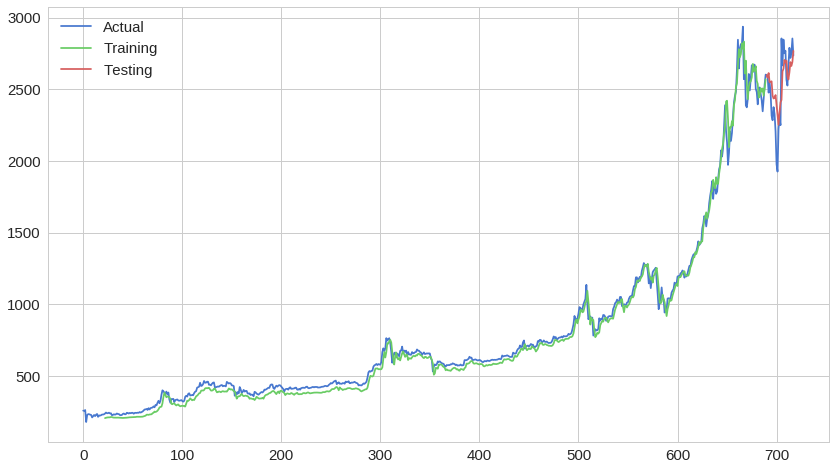

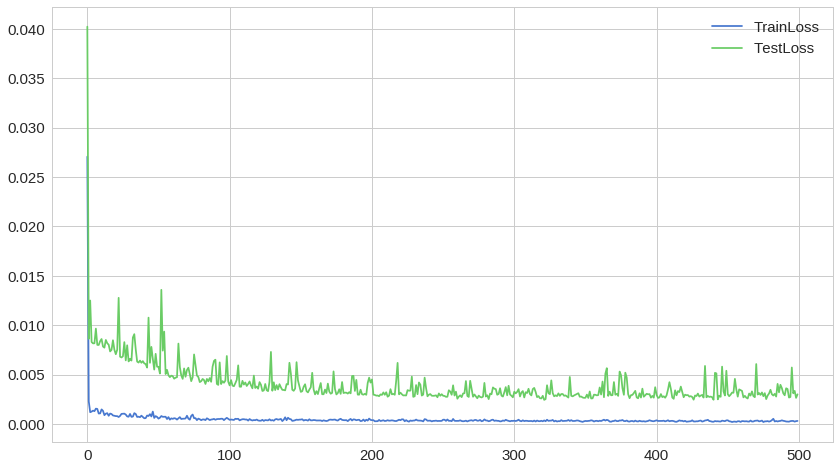

In [14]:
USDT_BTC = nextDayPrediction('USDT_BTC', 'poloniex' ) 

In [6]:
Testing = USDT_BTC[1]

## Проверка гипотезы по поправочному весовому коэффициенту


/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()



ActualData
 [ 2557.28305108  2530.52203406  2536.77220019  2515.55304633  2449.03536422
  2394.02208393  2387.98972261  2367.74886242  2313.801675    2201.70111667
  2109.76741107  2147.64596818  2198.43064531  2215.62043011  2428.74695341
  2508.06431215  2621.04287477  2664.505528    2699.45823078  2654.97215368
  2612.09831803  2631.39887802  2684.25965202  2695.83976802  2714.89317868
  2761.59545246  2753.22452993  2735.14968662]
Difference
 [  76.21029718   34.95465124   43.37913378   29.89191351  -33.37210648
  -64.14588482  -37.77639067  -36.70890126  -84.68172344 -181.11138333
 -240.23918072 -155.17019393  -87.32350508  -88.68474567   98.10022489
  117.97935122  164.92251344  156.40347721  159.4733675    94.96873571
   61.66057389  102.70527451  157.53846061  144.08244381  142.52843259
  174.88842121  137.7213561    97.23855381]
ErrorInPercent:
 [  2.98012757   1.38132175   1.71001298   1.18828397  -1.36266332
  -2.67941909  -1.58193272  -1.5503714   -3.65985228  -8.225975
 -1

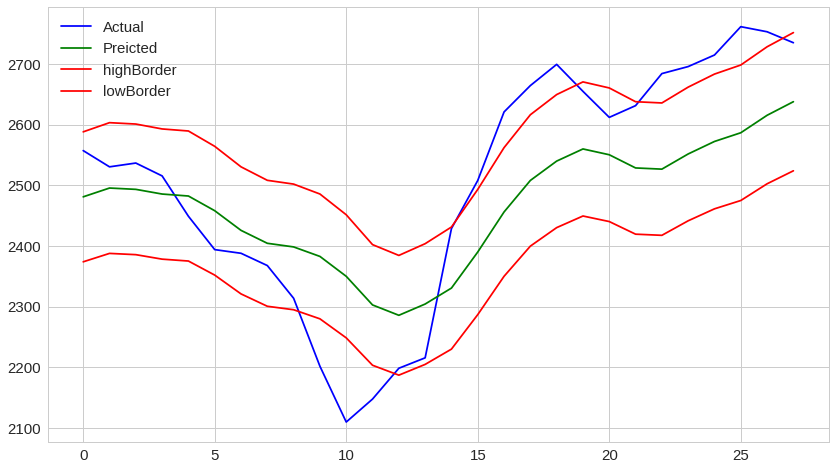

In [7]:
ActualData = np.array(pd.ewma(get_data.get_data_frame().close, 2))[-np.array(Testing.dropna()).shape[0]:]

# Проерка гипотезы поправочного весового коэффициента
TestingGraph = np.array(Testing.dropna())

print ('ActualData\n',ActualData)
Difference = ActualData - TestingGraph

print ('Difference\n',Difference)

ErrorInPercent = (Difference * 100 / ActualData)
MeanError = np.mean(np.abs(ErrorInPercent))

print('ErrorInPercent:\n', ErrorInPercent)
print('MeanError:\n', MeanError)

NewTestingOne = TestingGraph*(100+MeanError)/100
NewTestingTwo = TestingGraph*(100-MeanError)/100

plt.plot(ActualData, label = 'Actual', color = 'blue')
plt.plot(TestingGraph, label = 'Preicted', color = 'green')
plt.plot((NewTestingOne), label = 'highBorder', color = 'red')
plt.plot((NewTestingTwo), label = 'lowBorder', color = 'red')
plt.legend()
plt.show()

In [7]:
USDT_LTC = nextDayPrediction('USDT_LTC', 'poloniex')

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning:

pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()



START FIT MODEL...
Epoch 1/500
697/697 [==============================] - 1s - loss: 0.0333 - acc: 0.0014      
Epoch 2/500
697/697 [==============================] - 0s - loss: 0.0027 - acc: 0.0014     
Epoch 3/500
697/697 [==============================] - 0s - loss: 0.0030 - acc: 0.0014     
Epoch 4/500
697/697 [==============================] - 0s - loss: 0.0030 - acc: 0.0014     
Epoch 5/500
697/697 [==============================] - 0s - loss: 0.0020 - acc: 0.0014     
Epoch 6/500
697/697 [==============================] - 0s - loss: 0.0021 - acc: 0.0014     
Epoch 7/500
697/697 [==============================] - 0s - loss: 0.0021 - acc: 0.0014        
Epoch 8/500
697/697 [==============================] - 0s - loss: 0.0019 - acc: 0.0014        
Epoch 9/500
697/697 [==============================] - 0s - loss: 0.0014 - acc: 0.0014     
Epoch 10/500
697/697 [==============================] - 0s - loss: 0.0026 - acc: 0.0014       
Epoch 11/500
697/697 [=============================

697/697 [==============================] - 0s - loss: 3.7622e-04 - acc: 0.0014     
Epoch 168/500
697/697 [==============================] - 0s - loss: 3.4203e-04 - acc: 0.0014     
Epoch 169/500
697/697 [==============================] - 0s - loss: 2.9211e-04 - acc: 0.0014     
Epoch 170/500
697/697 [==============================] - 0s - loss: 3.3823e-04 - acc: 0.0014     
Epoch 171/500
697/697 [==============================] - 0s - loss: 2.9880e-04 - acc: 0.0014        
Epoch 172/500
697/697 [==============================] - 0s - loss: 3.3139e-04 - acc: 0.0014     
Epoch 173/500
697/697 [==============================] - 0s - loss: 3.9118e-04 - acc: 0.0014      
Epoch 174/500
697/697 [==============================] - 0s - loss: 6.0287e-04 - acc: 0.0014     
Epoch 175/500
697/697 [==============================] - 0s - loss: 3.0146e-04 - acc: 0.0014     
Epoch 176/500
697/697 [==============================] - 0s - loss: 2.4638e-04 - acc: 0.0014     
Epoch 177/500
697/697 [=======

697/697 [==============================] - 0s - loss: 2.3524e-04 - acc: 0.0014     
Epoch 333/500
697/697 [==============================] - 0s - loss: 2.0020e-04 - acc: 0.0014        
Epoch 334/500
697/697 [==============================] - 0s - loss: 2.3689e-04 - acc: 0.0014     
Epoch 335/500
697/697 [==============================] - 0s - loss: 2.0491e-04 - acc: 0.0014       
Epoch 336/500
697/697 [==============================] - 0s - loss: 2.6708e-04 - acc: 0.0014     
Epoch 337/500
697/697 [==============================] - 0s - loss: 1.5689e-04 - acc: 0.0014     
Epoch 338/500
697/697 [==============================] - 0s - loss: 1.7961e-04 - acc: 0.0014     
Epoch 339/500
697/697 [==============================] - 0s - loss: 1.3895e-04 - acc: 0.0014      
Epoch 340/500
697/697 [==============================] - 0s - loss: 1.7724e-04 - acc: 0.0014     
Epoch 341/500
697/697 [==============================] - 0s - loss: 2.0953e-04 - acc: 0.0014     
Epoch 342/500
697/697 [=====

697/697 [==============================] - 0s - loss: 3.3949e-04 - acc: 0.0014     
Epoch 416/500
697/697 [==============================] - 0s - loss: 2.4443e-04 - acc: 0.0014       
Epoch 417/500
697/697 [==============================] - 0s - loss: 1.5290e-04 - acc: 0.0014     
Epoch 418/500
697/697 [==============================] - 0s - loss: 1.9235e-04 - acc: 0.0014      
Epoch 419/500
697/697 [==============================] - 0s - loss: 1.5004e-04 - acc: 0.0014     
Epoch 420/500
697/697 [==============================] - 0s - loss: 1.5515e-04 - acc: 0.0014     
Epoch 421/500
697/697 [==============================] - 0s - loss: 1.6619e-04 - acc: 0.0014     
Epoch 422/500
697/697 [==============================] - 0s - loss: 1.7340e-04 - acc: 0.0014     
Epoch 423/500
697/697 [==============================] - 0s - loss: 1.7080e-04 - acc: 0.0014     
Epoch 424/500
697/697 [==============================] - 0s - loss: 1.3958e-04 - acc: 0.0014     
Epoch 425/500
697/697 [========

In [8]:
USDT_ETH = nextDayPrediction('USDT_ETH', 'poloniex')

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning:

pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()



START FIT MODEL...
Epoch 1/500
697/697 [==============================] - 276s - loss: 0.0235 - acc: 0.0029    
Epoch 2/500
697/697 [==============================] - 1s - loss: 0.0027 - acc: 0.0029     
Epoch 3/500
697/697 [==============================] - 0s - loss: 0.0024 - acc: 0.0029     
Epoch 4/500
697/697 [==============================] - 0s - loss: 0.0029 - acc: 0.0029     
Epoch 5/500
697/697 [==============================] - 0s - loss: 0.0019 - acc: 0.0029     
Epoch 6/500
697/697 [==============================] - 0s - loss: 0.0015 - acc: 0.0029     
Epoch 7/500
697/697 [==============================] - 0s - loss: 0.0012 - acc: 0.0029     
Epoch 8/500
697/697 [==============================] - 0s - loss: 0.0011 - acc: 0.0029     
Epoch 9/500
697/697 [==============================] - 0s - loss: 8.6978e-04 - acc: 0.0029     
Epoch 10/500
697/697 [==============================] - 0s - loss: 0.0011 - acc: 0.0029      
Epoch 11/500
697/697 [==============================] 

697/697 [==============================] - 0s - loss: 1.5184e-04 - acc: 0.0029     
Epoch 169/500
697/697 [==============================] - 0s - loss: 2.6453e-04 - acc: 0.0029     
Epoch 170/500
697/697 [==============================] - 0s - loss: 2.2100e-04 - acc: 0.0029     
Epoch 171/500
697/697 [==============================] - 0s - loss: 2.6947e-04 - acc: 0.0029     
Epoch 172/500
697/697 [==============================] - 0s - loss: 2.1018e-04 - acc: 0.0029     
Epoch 173/500
697/697 [==============================] - 0s - loss: 2.1410e-04 - acc: 0.0029     
Epoch 174/500
697/697 [==============================] - 0s - loss: 1.9826e-04 - acc: 0.0029     
Epoch 175/500
697/697 [==============================] - 0s - loss: 1.8585e-04 - acc: 0.0029         
Epoch 176/500
697/697 [==============================] - 0s - loss: 2.5152e-04 - acc: 0.0029     
Epoch 177/500
697/697 [==============================] - 0s - loss: 2.4432e-04 - acc: 0.0029     
Epoch 178/500
697/697 [=======

697/697 [==============================] - 0s - loss: 1.3637e-04 - acc: 0.0029     
Epoch 335/500
697/697 [==============================] - 0s - loss: 1.8199e-04 - acc: 0.0029     
Epoch 336/500
697/697 [==============================] - 0s - loss: 1.9626e-04 - acc: 0.0029     
Epoch 337/500
697/697 [==============================] - 0s - loss: 1.2667e-04 - acc: 0.0029     
Epoch 338/500
697/697 [==============================] - 0s - loss: 1.5144e-04 - acc: 0.0029       
Epoch 339/500
697/697 [==============================] - 0s - loss: 1.1057e-04 - acc: 0.0029     
Epoch 340/500
697/697 [==============================] - 0s - loss: 1.4592e-04 - acc: 0.0029       
Epoch 341/500
697/697 [==============================] - 0s - loss: 1.6020e-04 - acc: 0.0029     
Epoch 342/500
697/697 [==============================] - 0s - loss: 1.7576e-04 - acc: 0.0029     
Epoch 343/500
697/697 [==============================] - 0s - loss: 2.3282e-04 - acc: 0.0029     
Epoch 344/500
697/697 [=======

697/697 [==============================] - 0s - loss: 1.0585e-04 - acc: 0.0029      
Learning time:  752.2290806770325
            predictionPrice
2017-08-03       223.623337


In [5]:
USDT_ETC = nextDayPrediction('USDT_ETC', 'poloniex')

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning:

pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()



START FIT MODEL...
Epoch 1/500
349/349 [==============================] - 2s - loss: 0.0954 - acc: 0.0029        
Epoch 2/500
349/349 [==============================] - 0s - loss: 0.0186 - acc: 0.0057      
Epoch 3/500
349/349 [==============================] - 0s - loss: 0.0067 - acc: 0.0057     
Epoch 4/500
349/349 [==============================] - 0s - loss: 0.0049 - acc: 0.0057     
Epoch 5/500
349/349 [==============================] - 0s - loss: 0.0050 - acc: 0.0057     
Epoch 6/500
349/349 [==============================] - 0s - loss: 0.0038 - acc: 0.0057      
Epoch 7/500
349/349 [==============================] - 0s - loss: 0.0045 - acc: 0.0057     
Epoch 8/500
349/349 [==============================] - 0s - loss: 0.0042 - acc: 0.0057     
Epoch 9/500
349/349 [==============================] - 0s - loss: 0.0045 - acc: 0.0057      
Epoch 10/500
349/349 [==============================] - 0s - loss: 0.0051 - acc: 0.0057       
Epoch 11/500
349/349 [==============================

349/349 [==============================] - 0s - loss: 6.1800e-04 - acc: 0.0057        
Epoch 171/500
349/349 [==============================] - 0s - loss: 7.7969e-04 - acc: 0.0057      
Epoch 172/500
349/349 [==============================] - 0s - loss: 6.9011e-04 - acc: 0.0057         - ETA: 0s - loss: 7.3377e-04 - acc: 0.0000
Epoch 173/500
349/349 [==============================] - 0s - loss: 9.3461e-04 - acc: 0.0057     
Epoch 174/500
349/349 [==============================] - 0s - loss: 8.7844e-04 - acc: 0.0057     
Epoch 175/500
349/349 [==============================] - 0s - loss: 6.1349e-04 - acc: 0.0057        
Epoch 176/500
349/349 [==============================] - 0s - loss: 7.2455e-04 - acc: 0.0057     
Epoch 177/500
349/349 [==============================] - 0s - loss: 5.5951e-04 - acc: 0.0057     
Epoch 178/500
349/349 [==============================] - 0s - loss: 5.6266e-04 - acc: 0.0057     
Epoch 179/500
349/349 [==============================] - 0s - loss: 8.7097e-04 

349/349 [==============================] - 0s - loss: 3.9742e-04 - acc: 0.0057     
Epoch 335/500
349/349 [==============================] - 0s - loss: 4.3614e-04 - acc: 0.0057     
Epoch 336/500
349/349 [==============================] - 0s - loss: 5.4386e-04 - acc: 0.0057     
Epoch 337/500
349/349 [==============================] - 0s - loss: 3.7176e-04 - acc: 0.0057       
Epoch 338/500
349/349 [==============================] - 0s - loss: 4.0729e-04 - acc: 0.0057       
Epoch 339/500
349/349 [==============================] - 0s - loss: 5.0841e-04 - acc: 0.0057      
Epoch 340/500
349/349 [==============================] - 0s - loss: 3.3035e-04 - acc: 0.0057       
Epoch 341/500
349/349 [==============================] - 0s - loss: 4.2149e-04 - acc: 0.0057     
Epoch 342/500
349/349 [==============================] - 0s - loss: 4.3870e-04 - acc: 0.0057     
Epoch 343/500
349/349 [==============================] - 0s - loss: 3.5765e-04 - acc: 0.0057     
Epoch 344/500
349/349 [====

349/349 [==============================] - 0s - loss: 4.2970e-04 - acc: 0.0057     
Epoch 418/500
349/349 [==============================] - 0s - loss: 4.5176e-04 - acc: 0.0057        
Epoch 419/500
349/349 [==============================] - 0s - loss: 4.5781e-04 - acc: 0.0057      
Epoch 420/500
349/349 [==============================] - 0s - loss: 4.2479e-04 - acc: 0.0057      
Epoch 421/500
349/349 [==============================] - 0s - loss: 5.1654e-04 - acc: 0.0057     
Epoch 422/500
349/349 [==============================] - 0s - loss: 4.9172e-04 - acc: 0.0057        
Epoch 423/500
349/349 [==============================] - 0s - loss: 6.0293e-04 - acc: 0.0057        
Epoch 424/500
349/349 [==============================] - 0s - loss: 5.2934e-04 - acc: 0.0057     
Epoch 425/500
349/349 [==============================] - 0s - loss: 3.2759e-04 - acc: 0.0057        
Epoch 426/500
349/349 [==============================] - 0s - loss: 3.8712e-04 - acc: 0.0057         
Epoch 427/500
34

In [6]:
USDT_XRP = nextDayPrediction('USDT_XRP', 'poloniex',N = 1)

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning:

pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()



START FIT MODEL...
Epoch 1/500
697/697 [==============================] - 1s - loss: 0.0264 - acc: 0.0014       
Epoch 2/500
697/697 [==============================] - 0s - loss: 0.0060 - acc: 0.0029     
Epoch 3/500
697/697 [==============================] - 0s - loss: 0.0029 - acc: 0.0029     
Epoch 4/500
697/697 [==============================] - 0s - loss: 0.0032 - acc: 0.0029     
Epoch 5/500
697/697 [==============================] - 0s - loss: 0.0026 - acc: 0.0029     
Epoch 6/500
697/697 [==============================] - 0s - loss: 0.0019 - acc: 0.0029     
Epoch 7/500
697/697 [==============================] - 0s - loss: 0.0028 - acc: 0.0029     
Epoch 8/500
697/697 [==============================] - 0s - loss: 0.0023 - acc: 0.0029     
Epoch 9/500
697/697 [==============================] - 0s - loss: 0.0014 - acc: 0.0029     
Epoch 10/500
697/697 [==============================] - 0s - loss: 0.0012 - acc: 0.0029     
Epoch 11/500
697/697 [==============================] - 0s

697/697 [==============================] - 0s - loss: 3.1713e-04 - acc: 0.0029     
Epoch 170/500
697/697 [==============================] - 0s - loss: 2.9938e-04 - acc: 0.0029     
Epoch 171/500
697/697 [==============================] - 0s - loss: 3.5219e-04 - acc: 0.0029     
Epoch 172/500
697/697 [==============================] - 0s - loss: 3.4667e-04 - acc: 0.0029     
Epoch 173/500
697/697 [==============================] - 0s - loss: 4.8115e-04 - acc: 0.0029     
Epoch 174/500
697/697 [==============================] - 0s - loss: 3.0334e-04 - acc: 0.0029     
Epoch 175/500
697/697 [==============================] - 0s - loss: 3.4310e-04 - acc: 0.0029     
Epoch 176/500
697/697 [==============================] - 0s - loss: 3.3539e-04 - acc: 0.0029     
Epoch 177/500
697/697 [==============================] - 0s - loss: 3.0614e-04 - acc: 0.0029     
Epoch 178/500
697/697 [==============================] - 0s - loss: 2.6599e-04 - acc: 0.0029     
Epoch 179/500
697/697 [===========

697/697 [==============================] - 0s - loss: 2.2041e-04 - acc: 0.0029     
Epoch 336/500
697/697 [==============================] - 0s - loss: 3.9896e-04 - acc: 0.0029     
Epoch 337/500
697/697 [==============================] - 0s - loss: 2.4520e-04 - acc: 0.0029     
Epoch 338/500
697/697 [==============================] - 0s - loss: 1.5945e-04 - acc: 0.0029     
Epoch 339/500
697/697 [==============================] - 0s - loss: 2.2384e-04 - acc: 0.0029     
Epoch 340/500
697/697 [==============================] - 0s - loss: 2.4430e-04 - acc: 0.0029     
Epoch 341/500
697/697 [==============================] - 0s - loss: 1.7134e-04 - acc: 0.0029     
Epoch 342/500
697/697 [==============================] - 0s - loss: 1.9162e-04 - acc: 0.0029     
Epoch 343/500
697/697 [==============================] - 0s - loss: 1.8755e-04 - acc: 0.0029     
Epoch 344/500
697/697 [==============================] - 0s - loss: 2.5485e-04 - acc: 0.0029     
Epoch 345/500
697/697 [===========

In [86]:
print ('predictionValues on', datetime.date.today())

allCurrency = ['USDT_BTC', 'USDT_LTC', 'USDT_ETH', 'USDT_ETC', 'USDT_XRP']
predictedValues = [USDT_BTC, USDT_LTC, USDT_ETH, USDT_ETC, USDT_XRP]

for index in np.arange(len(allCurrency)):
    print(allCurrency[index], '\n' , predictedValues[index] )


predictionValues on 2017-07-26
USDT_BTC 
             predictionPrice
2017-07-26      2545.130371
USDT_LTC 
             predictionPrice
2017-07-26        42.890644
USDT_ETH 
             predictionPrice
2017-07-26       193.827957
USDT_ETC 
             predictionPrice
2017-07-26        14.239629
USDT_XRP 
             predictionPrice
2017-07-26         0.177823


In [63]:
def checkTrend(typeBlockchain, stock, predicted):
    
    df = get_data_frame(typeBlockchain, stock)
    lastValue = df.close[df.shape[0]-1]
    change = (predicted.values * 100 / lastValue) - 100
    if change > 0:
        mark = 'PositiveTrend'
    else: mark = 'NegativeTrend'
        
    print ('-'*10 + '\nSTOCK:%s, type:%s\n'%(stock, typeBlockchain))
    print ('Change between last (%f) and predicted values(%f) = %f perc.\n%s' \
           % (lastValue, predicted.values, change, mark))

In [84]:
stock = 'poloniex'

for index in np.arange(len(allCurrency)):
    checkTrend(allCurrency[index], stock , predictedValues[index] )

----------
STOCK:poloniex, type:USDT_BTC

Change between last (2565.999999) and predicted values(2545.130371) = -0.813316 perc.
NegativeTrend
----------
STOCK:poloniex, type:USDT_LTC

Change between last (42.110000) and predicted values(42.890644) = 1.853821 perc.
PositiveTrend
----------
STOCK:poloniex, type:USDT_ETH

Change between last (203.000000) and predicted values(193.827957) = -4.518250 perc.
NegativeTrend
----------
STOCK:poloniex, type:USDT_ETC

Change between last (14.620000) and predicted values(14.239629) = -2.601715 perc.
NegativeTrend
----------
STOCK:poloniex, type:USDT_XRP

Change between last (0.174540) and predicted values(0.177823) = 1.881226 perc.
PositiveTrend
